In [1404]:
# YIKAI MAO

# quantum query algorithm generator

In [1405]:
# reproducibility
%env PYTHONHASHSEED=0

# Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from qiskit.transpiler.passes import RemoveBarriers
from qiskit.circuit.library import Diagonal, QFT, GroverOperator, ZGate

print('*'*104)
print("available simulators:")
display(Aer.backends())
print('*'*104)

# other libraries
from tqdm import tqdm #tqdm(iterable)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as trans
from sklearn.metrics import r2_score
import pickle

env: PYTHONHASHSEED=0
********************************************************************************************************
available simulators:


[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

********************************************************************************************************


In [1406]:
# utility functions

def run_ideal_simulation(circuit, shots, optimization_level, seed, show_plot, show_counts):
    # assume perfect device with no noise
    # circuit = circuit to simulate, not transpiled
    # shots = how many shots to run
    # optimization_level = passed to the transpiler, min = 0, max = 3
    # seed = random seed for simultaion, can be None
    # show_counts = T/F, plot result or not

    simulator = Aer.get_backend('aer_simulator')
    temp_qc = transpile(circuit, simulator, optimization_level=optimization_level)
    job_temp = simulator.run(temp_qc, shots=shots, seed_simulator=seed)
    temp_results = job_temp.result()
    
    # build simulation result dict
    raw_counts = temp_results.get_counts()
    # print("raw counts:\n", raw_counts)
    num_clbits = circuit.num_clbits
    ideal_result_dict = {}

    # sorting the raw counts, add state zero
    for i in range(pow(2, num_clbits)):
        bin_str = format(i, str('0>' + str(num_clbits) + 'b'))
        if bin_str not in raw_counts:
            ideal_result_dict[bin_str] = 0
        else:
            ideal_result_dict[bin_str] = raw_counts[bin_str]

    if show_plot:
        plot = plot_histogram(raw_counts, title='ideal simulation')
        display(plot)
            
    if show_counts:
        print('sorted counts:')
        print(ideal_result_dict)
    
    return ideal_result_dict, raw_counts

def decomposer(circ, level=1):
    # decompose the circuit to see the basis gates
    # level = how many times to decompose
    
    decomposed_circ = circ
    
    for i in range(level):
        decomposed_circ = decomposed_circ.decompose()
        
    return decomposed_circ

# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def random_bin_str(width, zero=False):
    # return random binary string based on width
    # zero = T/F, T = include 0, F = do not return 0
    # width cannot be 0
    
    if width == 0:
        return None
    
    b = np.random.randint(2, size=width)
    b_str = ''.join(map(str, b.tolist()))
    
    if zero==True:
        return b_str
    
    else:
        while '1' not in b_str:
            b = np.random.randint(2, size=width)
            b_str = ''.join(map(str, b.tolist()))
        
        return b_str

In [1407]:
# https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/deutsch-jozsa.ipynb

def deutsch_jozsa(n, options=[]):
    # n is problem size, NOT necessarily equal to the qubit count of the generated circuit
    # n = number of qubits of the oracle
    # options = [oracle, print_oracle]
    # oracle = 'constant' (easy), 'balanced' (hard)
    # print_oracle = T/F
    
    oracle = options[0]
    print_oracle = options[1]
    
    dj_circuit = QuantumCircuit(n+1, n)
    
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
        
    # Let's append the oracle gate to our circuit:
    dj_circuit.barrier(list(range(n+1)))
    
    deutsch_jozsa_oracle = QuantumCircuit(n+1)
    
    if oracle == 'constant':
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            deutsch_jozsa_oracle.x(n)
    
    if oracle == 'balanced':
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b_str = random_bin_str(n, False)
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                deutsch_jozsa_oracle.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            deutsch_jozsa_oracle.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                deutsch_jozsa_oracle.x(qubit)
                
    # else:
    #     # user-defined oracle here
    
    if print_oracle:
        if oracle == 'constant':
            print("constant " + str(output) + " oracle")
        if oracle == 'balanced':
            # reverse s to fit qiskit's qubit ordering
            print("balanced oracle =", b_str[::-1])
        display(decomposer(deutsch_jozsa_oracle, 0).draw(style="iqp-dark"))
    
    deutsch_jozsa_oracle = deutsch_jozsa_oracle.to_gate()
    deutsch_jozsa_oracle.name = "dj_oracle" # To show when we display the circuit
    
    dj_circuit.append(deutsch_jozsa_oracle, range(n+1))
    dj_circuit.barrier(list(range(n+1)))
    
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [1408]:
# https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/bernstein-vazirani.ipynb

def bernstein_vazirani(n, options=[]):
    # n is problem size, NOT necessarily equal to the qubit count of the generated circuit
    # n = number of qubits of the oracle
    # options = [oracle, print_oracle]
    # oracle = 'random'
    # print_oracle = T/F
    
    oracle = options[0]
    print_oracle = options[1]
    
    # We need a circuit with n qubits, plus one auxiliary qubit
    # Also need n classical bits to write the output to
    bv_circuit = QuantumCircuit(n+1, n)
    
    # put auxiliary in state |->
    bv_circuit.h(n)
    bv_circuit.z(n)
    
    # Apply Hadamard gates before querying the oracle
    for i in range(n):
        bv_circuit.h(i)
        
    # Apply barrier 
    bv_circuit.barrier()
    
    bernstein_vazirani_oracle = QuantumCircuit(n+1)
    
    # if oracle == ???:
    #     # user-defined oracle here
    
    s_str = random_bin_str(n, False)
    
    if print_oracle:
        # reverse s to fit qiskit's qubit ordering
        print("oracle =", s_str[::-1])
    
    for q in range(n):
        if s_str[q] == '0':
            bernstein_vazirani_oracle.id(q)
        else:
            bernstein_vazirani_oracle.cx(q, n)
    
    bernstein_vazirani_oracle = bernstein_vazirani_oracle.to_gate()
    bernstein_vazirani_oracle.name = "bv_oracle"
    
    bv_circuit.append(bernstein_vazirani_oracle, range(n+1))
            
    # Apply barrier 
    bv_circuit.barrier()
    
    #Apply Hadamard gates after querying the oracle
    for i in range(n):
        bv_circuit.h(i)
    
    # Measurement
    for i in range(n):
        bv_circuit.measure(i, i)
    
    return bv_circuit

In [1409]:
# https://github.com/qiskit-community/qiskit-textbook/blob/main/
#     qiskit-textbook-src/qiskit_textbook/tools/__init__.py

def simon(n, options=[]):
    # n is problem size, NOT necessarily equal to the qubit count of the generated circuit
    # n = number of qubits of the oracle
    # options = [oracle, print_oracle]
    # oracle = 'random'
    # print_oracle = T/F
    
    oracle = options[0]
    print_oracle = options[1]
    
    simon_circuit = QuantumCircuit(n*2, n)

    # Apply Hadamard gates before querying the oracle
    simon_circuit.h(range(n))    
    
    # Apply barrier for visual separation
    simon_circuit.barrier()

    # if oracle == ???:
    #     # user-defined oracle here
    
    simon_oracle = QuantumCircuit(n*2)
    
    b_str = random_bin_str(n, True)
    
    # Do copy; |x>|0> -> |x>|x>
    for q in range(n):
        simon_oracle.cx(q, q+n)
    
    # 1:1 mapping, so just exit
    if '1' not in b_str: 
        return simon_oracle
    
    # index of first non-zero bit in b
    i = b_str.find('1')
    
    # Do |x> -> |s.x> on condition that q_i is 1
    for q in range(n):
        if b_str[q] == '1':
            simon_oracle.cx(i, (q)+n)
    
    if print_oracle:
        # reverse s to fit qiskit's qubit ordering
        print("oracle =", b_str[::-1])
        display(decomposer(simon_oracle, 0).draw(style="iqp-dark"))
    
    simon_oracle = simon_oracle.to_gate()
    simon_oracle.name = "simon_oracle"
    
    simon_circuit.append(simon_oracle, range(n*2))

    # Apply barrier for visual separation
    simon_circuit.barrier()

    # Apply Hadamard gates to the input register
    simon_circuit.h(range(n))

    # Measure qubits
    simon_circuit.measure(range(n), range(n))
    
    return simon_circuit

def simon_verify(b, counts):
    # verify the output of simon circuit
    
    verified = True
    
    for z in counts:
        # Calculate the dot product of the results
        accum = 0
        for i in range(len(b)):
            accum += int(b[i]) * int(z[i])
        bdotz = accum % 2
        
        print('{}.{} = {} (mod 2)'.format(b, z, bdotz))
        
        if bdotz != 0:
            verified = False
    
    if verified:
        print("Passed")
    else:
        print("Failed")
        
    return None

balanced oracle = 1110


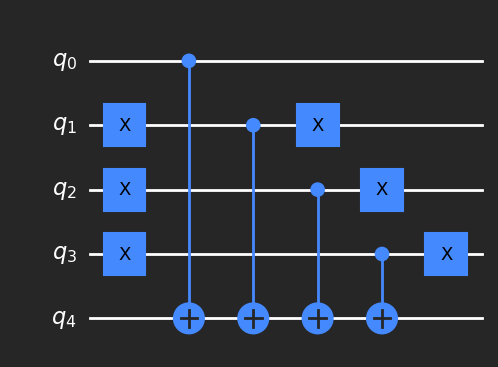

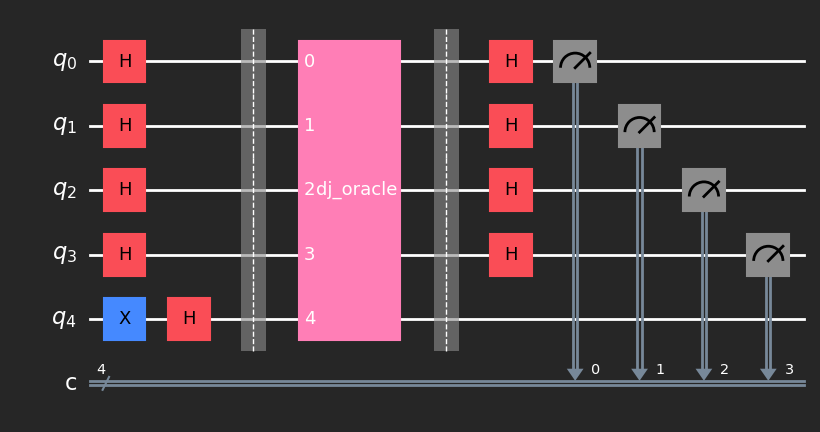

In [1410]:
n = 4
oracle = 'balanced'
print_oracle=True

dj_qc = deutsch_jozsa(n, [oracle, print_oracle])

decomposer(dj_qc, 0).draw(style="iqp-dark") #iqp, iqp-dark, textbook, bw, clifford

oracle = 1111


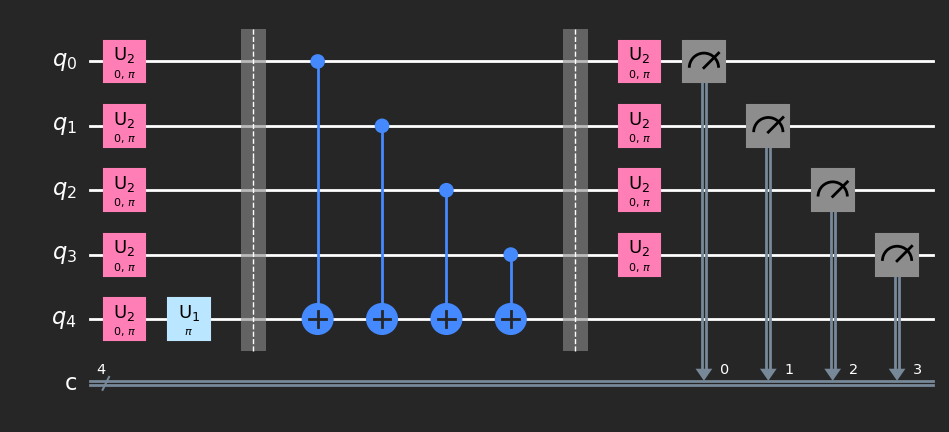

In [1411]:
n = 4
oracle = 'random'
print_oracle=True

bv_qc = bernstein_vazirani(n, [oracle, print_oracle])

decomposer(bv_qc, 1).draw(style="iqp-dark") #iqp, iqp-dark, textbook, bw, clifford

oracle = 1010


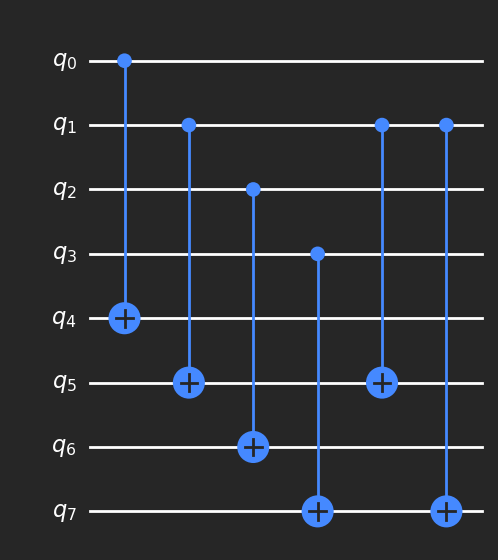

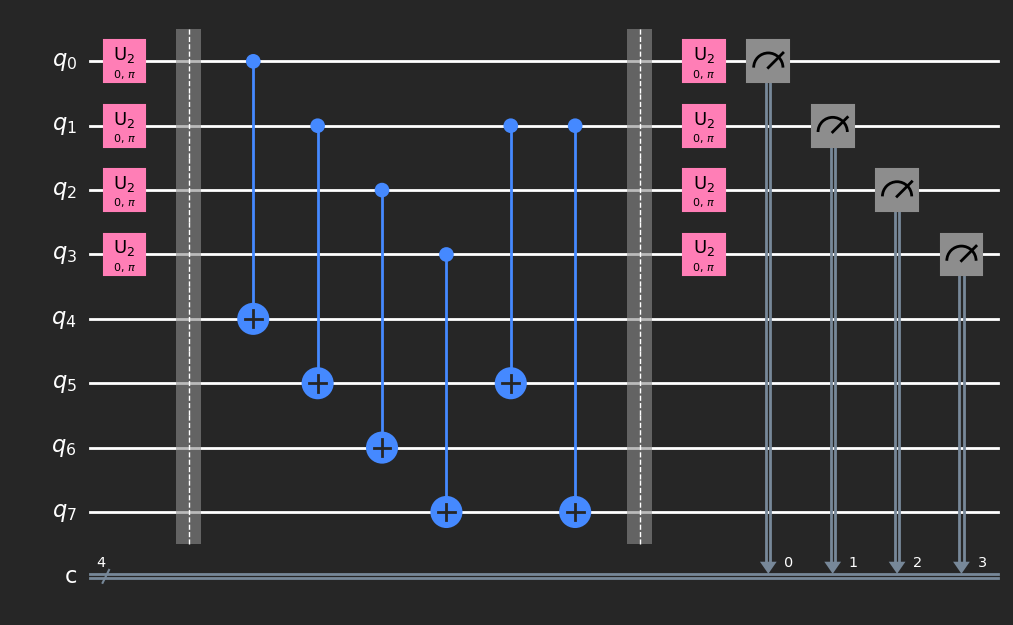

In [1412]:
n = 4
oracle = 'random'
print_oracle=True

simon_qc = simon(n, [oracle, print_oracle])

decomposer(simon_qc, 1).draw(style="iqp-dark") #iqp, iqp-dark, textbook, bw, clifford

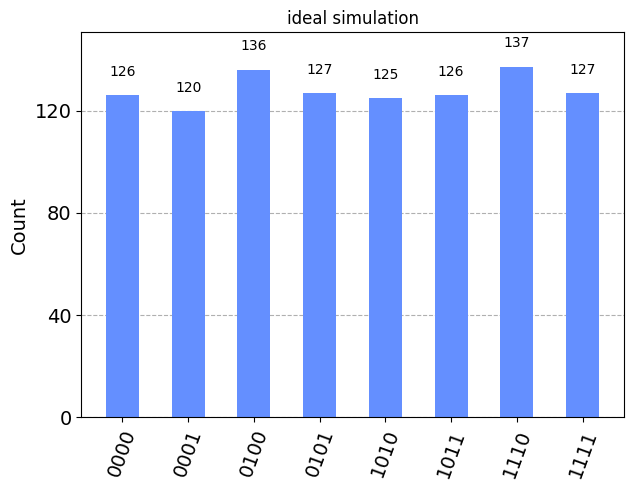

1010.0000 = 0 (mod 2)
1010.0100 = 0 (mod 2)
1010.1010 = 0 (mod 2)
1010.1011 = 0 (mod 2)
1010.0101 = 0 (mod 2)
1010.1110 = 0 (mod 2)
1010.1111 = 0 (mod 2)
1010.0001 = 0 (mod 2)
Passed
CPU times: user 196 ms, sys: 109 ms, total: 305 ms
Wall time: 185 ms


In [1415]:
%%time

qc = simon_qc
shots = 1024
optimization_level = 0
seed = None
show_plot = True
show_counts = False

sorted_counts, raw_counts = run_ideal_simulation(qc, shots, optimization_level, seed, show_plot, show_counts)
simon_verify('1010', raw_counts)